# Imports

In [0]:
# inspect python version
import platform
print("Python Version", platform.python_version_tuple())

Python Version ('3', '6', '9')


In [0]:
# Check if in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
print("IN_COLAB", IN_COLAB)

if IN_COLAB:
    # Mount google drive
    from google.colab import drive
    drive.mount('/content/drive')
    # drive.mount('/content/drive', force_remount=True)

    # update path to import modules from a folder in google drive.
    PROJECT_PATH = '/content/drive/My Drive/Unterlagen/MeinStudium/(6)_WiSe 2019-2020/Bachelor/BaBa/'
    sys.path.append(PROJECT_PATH)

    TORCH_DEVICE = 'cuda'
else:
    PROJECT_PATH = ''
    TORCH_DEVICE = 'cpu'

IN_COLAB True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# torch
import torch
import torch.nn as nn
print("PyTorch Version", torch.__version__, "GPU", torch.cuda.get_device_name(), "GPU Capability",
      torch.cuda.get_device_capability(), "CUDA Version", torch.version.cuda,
      "CUDA available", torch.cuda.is_available())

PyTorch Version 1.4.0 GPU Tesla P100-PCIE-16GB GPU Capability (6, 0) CUDA Version 10.1 CUDA available True


In [0]:
!pip install ipython-autotime
%load_ext autotime

In [0]:
# other modules
import os
import time
import math
import numpy as np
import PIL.Image
from ipywidgets import IntProgress
import imageio
import cv2

import IPython.display
import IPython
print("IPython", IPython.__version__)

import matplotlib
print("matplotlib", matplotlib.__version__)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
if IN_COLAB:
    %matplotlib inline
else:
    %matplotlib notebook



import sklearn.metrics
from skimage import measure

IPython 5.5.0
matplotlib 3.1.3
time: 442 ms


In [0]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
        <p>{value} / {max}</p>
    """.format(value=value, max=max))

time: 2.1 ms


# Load data

In [0]:
originalImagesPath = os.path.join(PROJECT_PATH, "inputImages/")
scribbleImagesPath = os.path.join(PROJECT_PATH, "scribbleData/")
segmentedImagesPath = os.path.join(PROJECT_PATH, "segmentedData/")
validationImagesPath = os.path.join(PROJECT_PATH, "validationData/")

originalImagesPath = os.path.join(PROJECT_PATH, "inputImages/Atlaszeder/")
scribbleImagesPath = os.path.join(PROJECT_PATH, "scribbleData/Atlaszeder/")
segmentedImagesPath = os.path.join(PROJECT_PATH, "segmentedData/Atlaszeder/")
validationImagesPath = os.path.join(PROJECT_PATH, "validationData/Atlaszeder/")

time: 5.86 ms


/content/drive/My Drive/Unterlagen/MeinStudium/(6)_WiSe 2019-2020/Bachelor/BaBa/inputImages/Atlaszeder/DJI_0329.JPG
/content/drive/My Drive/Unterlagen/MeinStudium/(6)_WiSe 2019-2020/Bachelor/BaBa/scribbleData/Atlaszeder/DJI_0329Scribble_20200202_152621.png
['DJI_0164.png', 'DJI_0329.png', 'DJI_0174.png', 'DJI_0184.png', 'DJI_0194.png', 'DJI_0204.png', 'DJI_0213.png', 'DJI_0224.png', 'DJI_0234.png', 'DJI_0247.png', 'DJI_0254.png', 'DJI_0264.png', 'DJI_0274.png', 'DJI_0294.png', 'DJI_0304.png']


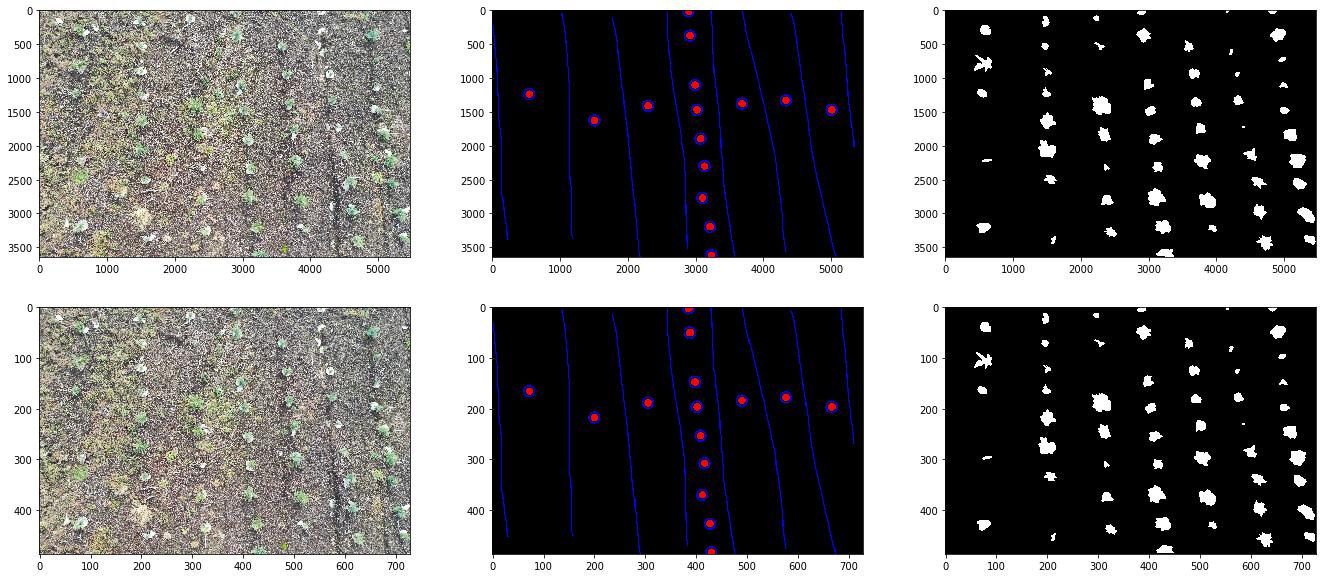

time: 5.69 s


In [0]:
#files = [f for f in os.listdir(originalImagesPath) if os.path.isfile(os.path.join(originalImagesPath, f))]

# choose file
#i = np.random.randint(0, len(files))
#originalImageFilename = files[i]

# overwrite temorarily
originalImageFilename = "DJI_0329.JPG"

originalImagePath = os.path.join(originalImagesPath, originalImageFilename)
print(originalImagePath)

#---------------------------------------------------------------------------------------------------------

# get all scribble files related to originalImageFilename
files = [f for f in os.listdir(scribbleImagesPath) if os.path.isfile(os.path.join(scribbleImagesPath, f))]
files = [f for f in files if f[: len(originalImageFilename) - 4] == originalImageFilename[:-4]]
files.sort()

scribbleImageFilename = files[-1]  # pick the newest file
scribbleImagePath = os.path.join(scribbleImagesPath, scribbleImageFilename)
print(scribbleImagePath)

#---------------------------------------------------------------------------------------------------------

files = [f for f in os.listdir(validationImagesPath) if os.path.isfile(os.path.join(validationImagesPath, f))]
print(files)
files = [f for f in files if f[: len(originalImageFilename) - 4] == originalImageFilename[:-4]]
files.sort()

validationImageFilename = files[-1]  # pick the newest file
validationImagePath = os.path.join(validationImagesPath, validationImageFilename)


# read images
colorMatOriginal = imageio.imread(originalImagePath)
scribbleMatOriginalWithAlpha = imageio.imread(scribbleImagePath)
scribbleMatOriginal = scribbleMatOriginalWithAlpha[..., :3]  # get rid of alpha channel
validationMatOriginal = imageio.imread(validationImagePath)

# scale down
#newSize = (int(colorMatOriginal.shape[1] / 10), int(colorMatOriginal.shape[0] / 10))
newSize = (729, 486)
colorMat = cv2.resize(colorMatOriginal, dsize=newSize)
scribbleMatOriginalWithAlpha = cv2.resize(scribbleMatOriginalWithAlpha, dsize=newSize)
scribbleMat = cv2.resize(scribbleMatOriginal, dsize=newSize)
validationMat = cv2.resize(validationMatOriginal, dsize=newSize)
validationMat = cv2.threshold(validationMat, 127, 255, cv2.THRESH_BINARY)[1]


# display images
fig, axs = plt.subplots(2, 3, figsize=(23, 10))
axs[0, 0].imshow(colorMatOriginal, vmin=0, vmax=255)
axs[0, 1].imshow(scribbleMatOriginal, vmin=0, vmax=255)
axs[0, 2].imshow(validationMatOriginal, cmap='gray', vmin=0, vmax=255)
axs[1, 0].imshow(colorMat, vmin=0, vmax=255)
axs[1, 1].imshow(scribbleMat, vmin=0, vmax=255)
axs[1, 2].imshow(validationMat, cmap='gray', vmin=0, vmax=255)
plt.show()

# Global definitions

In [0]:
# Get dimensions
imageHeight = colorMat.shape[0]
imageWidth = colorMat.shape[1]
print("Image dimensions HxW", imageHeight, imageWidth)

patchSize = 16  # 16x16 sourrounding patch for each pixel
padAmount = math.ceil((patchSize - 1) / 2)
print (padAmount)

Image dimensions HxW 486 729
8
time: 3.68 ms


# Prepare train data

In [0]:
def prepareTrainData(colorMat_, scribbleMat_):
    scribbleMat_ = np.delete(scribbleMat_, 1, 2)  # 1(green) 2(axis for colors)
    scribbleMat_ = np.minimum(scribbleMat_, 1)  # interval [0, 1]
    print("scribbleMat_", scribbleMat_.shape)

    # normalize colorMat_ and add padding
    colorMat_ = np.divide(colorMat_, 255.0)
    colorMat_ = np.pad(colorMat_, ((padAmount, padAmount), (padAmount, padAmount), (0, 0)), mode='edge')
    colorMat_ = np.moveaxis(colorMat_, 2, 0)  # fit to Network requirements NxCxHxW later    
    print("colorMat_", colorMat_.shape)

    coordMat = np.indices((imageHeight, imageWidth)).transpose((1, 2, 0)).astype(np.float32)
    coordMat[:, :, 0] = coordMat[:, :, 0] / imageHeight
    coordMat[:, :, 1] = coordMat[:, :, 1] / imageWidth
    coordMat_PosChannel = np.pad(coordMat, ((padAmount, padAmount), (padAmount, padAmount), (0, 0)), mode='edge') 
    print("coordMat", coordMat.shape)
    print("coordMat_PosChannel", coordMat_PosChannel.shape)

    xs_eval_Color = []
    xs_eval_Color_PosChannel = []
    xs_eval_Position = coordMat.reshape(coordMat.shape[0] * coordMat.shape[1], coordMat.shape[2])

    
    xs_labeled_Color = []
    xs_labeled_Color_PosChannel = []
    xs_labeled_Position = []
    ys_labeled = []


    for y in range(imageHeight):
        for x in range(imageWidth):
            patchCol = colorMat_[:, y: y + patchSize, x: x + patchSize]  #  (3, 16, 16)
            xs_eval_Color.append(patchCol)
            patchPos = coordMat_PosChannel[y: y + patchSize, x: x + patchSize, :]  #  (16, 16, 2)
            xs_eval_Color_PosChannel.append(patchPos)
            if scribbleMat_[y, x].sum() > 0:  # is labeled
                xs_labeled_Color.append(patchCol)
                xs_labeled_Color_PosChannel.append(patchPos)
                xs_labeled_Position.append(coordMat[y, x])
                ys_labeled.append(scribbleMat_[y, x])

    xs_eval_Color = np.array(xs_eval_Color)
    xs_eval_Color_PosChannel = np.array(xs_eval_Color_PosChannel)
    xs_eval_Position = np.array(xs_eval_Position)
    xs_labeled_Color = np.array(xs_labeled_Color)
    xs_labeled_Color_PosChannel = np.array(xs_labeled_Color_PosChannel)
    xs_labeled_Position = np.array(xs_labeled_Position)
    ys_labeled = np.array(ys_labeled)
    ys_labeled = 1 - np.argmax(ys_labeled, axis=1)  # 1 if baum, else 0
    
    print("xs_labeled_Color", xs_labeled_Color.shape, "xs_labeled_Color_PosChannel", xs_labeled_Color_PosChannel.shape, "xs_labeled_Position", xs_labeled_Position.shape, "ys_labeled", ys_labeled.shape)

    # shuffle labeled data
    permutation = np.random.permutation(ys_labeled.shape[0])
    xs_labeled_Color = xs_labeled_Color[permutation]
    xs_labeled_Color_PosChannel = xs_labeled_Color_PosChannel[permutation]
    xs_labeled_Position = xs_labeled_Position[permutation]
    ys_labeled = ys_labeled[permutation]

    splitIndex = int(0.80 * len(ys_labeled))  # 80% train 20% test
    xs_train_Color, xs_test_Color = xs_labeled_Color[:splitIndex], xs_labeled_Color[splitIndex:]
    xs_train_Color_PosChannel, xs_test_Color_PosChannel = xs_labeled_Color_PosChannel[:splitIndex], xs_labeled_Color_PosChannel[splitIndex:]
    xs_train_Position, xs_test_Position = xs_labeled_Position[:splitIndex], xs_labeled_Position[splitIndex:]
    ys_train, ys_test = ys_labeled[:splitIndex], ys_labeled[splitIndex:]

    return xs_train_Color, xs_train_Color_PosChannel, xs_train_Position, ys_train, xs_test_Color, xs_test_Color_PosChannel, xs_test_Position, ys_test, xs_eval_Color, xs_eval_Color_PosChannel, xs_eval_Position

time: 82.4 ms


In [0]:
xs_train_Color, xs_train_Color_PosChannel, xs_train_Position, ys_train, xs_test_Color, xs_test_Color_PosChannel, xs_test_Position, ys_test, xs_eval_Color, xs_eval_Color_PosChannel, xs_eval_Position = prepareTrainData(colorMat, scribbleMat)
print("xs_train_Color shape:", xs_train_Color.shape)
print("xs_train_Color_PosChannel shape:", xs_train_Color_PosChannel.shape)
print("xs_train_Position shape:", xs_train_Position.shape)
print("ys_train shape:", ys_train.shape)

print("xs_test_Color shape:", xs_test_Color.shape)
print("xs_test_Position shape:", xs_test_Position.shape)
print("xs_test_Color_PosChannel shape:", xs_test_Color_PosChannel.shape)
print("ys_test shape:", ys_test.shape)#, "TreeNum", ys_test[:, 0].sum())

print("xs_eval_Color shape:", xs_eval_Color.shape)
print("xs_eval_Color_PosChannel shape:", xs_eval_Color_PosChannel.shape)
print("xs_eval_Position shape:", xs_eval_Position.shape)

# transform to torch tensors
tensor_xs_train_Color = torch.from_numpy(xs_train_Color).float()
tensor_xs_train_Color_PosChannel = torch.from_numpy(xs_train_Color_PosChannel).float()
tensor_xs_train_Position = torch.from_numpy(xs_train_Position).float()
tensor_ys_train = torch.from_numpy(ys_train).float()

tensor_xs_test_Color = torch.from_numpy(xs_test_Color).float()
tensor_xs_test_Color_PosChannel = torch.from_numpy(xs_test_Color_PosChannel).float()
tensor_xs_test_Position = torch.from_numpy(xs_test_Position).float()

tensor_xs_eval_Color = torch.from_numpy(xs_eval_Color).float()
tensor_xs_eval_Color_PosChannel = torch.from_numpy(xs_eval_Color_PosChannel).float()
tensor_xs_eval_Position = torch.from_numpy(xs_eval_Position).float()
#print(tensor_xs_eval.element_size() * tensor_xs_eval.nelement()) # tensor memory usage

train_dataset = torch.utils.data.TensorDataset(tensor_xs_train_Color, tensor_xs_train_Color_PosChannel, tensor_xs_train_Position, tensor_ys_train) # create datset
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 6}
train_dataloader = torch.utils.data.DataLoader(train_dataset, **params) # create dataloader

inference_dataset = torch.utils.data.TensorDataset(tensor_xs_eval_Color, tensor_xs_eval_Color_PosChannel, tensor_xs_eval_Position) # create datset
inferenceParams = {'batch_size': 128,
                   'shuffle': False,
                   'num_workers': 6}
inference_dataloader = torch.utils.data.DataLoader(inference_dataset, **inferenceParams) # create dataloader

scribbleMat_ (486, 729, 2)
colorMat_ (3, 502, 745)
coordMat (486, 729, 2)
coordMat_PosChannel (502, 745, 2)
xs_labeled_Color (14435, 3, 16, 16) xs_labeled_Color_PosChannel (14435, 16, 16, 2) xs_labeled_Position (14435, 2) ys_labeled (14435,)
xs_train_Color shape: (11548, 3, 16, 16)
xs_train_Color_PosChannel shape: (11548, 16, 16, 2)
xs_train_Position shape: (11548, 2)
ys_train shape: (11548,)
xs_test_Color shape: (2887, 3, 16, 16)
xs_test_Position shape: (2887, 2)
xs_test_Color_PosChannel shape: (2887, 16, 16, 2)
ys_test shape: (2887,)
xs_eval_Color shape: (354294, 3, 16, 16)
xs_eval_Color_PosChannel shape: (354294, 16, 16, 2)
xs_eval_Position shape: (354294, 2)
time: 4.54 s


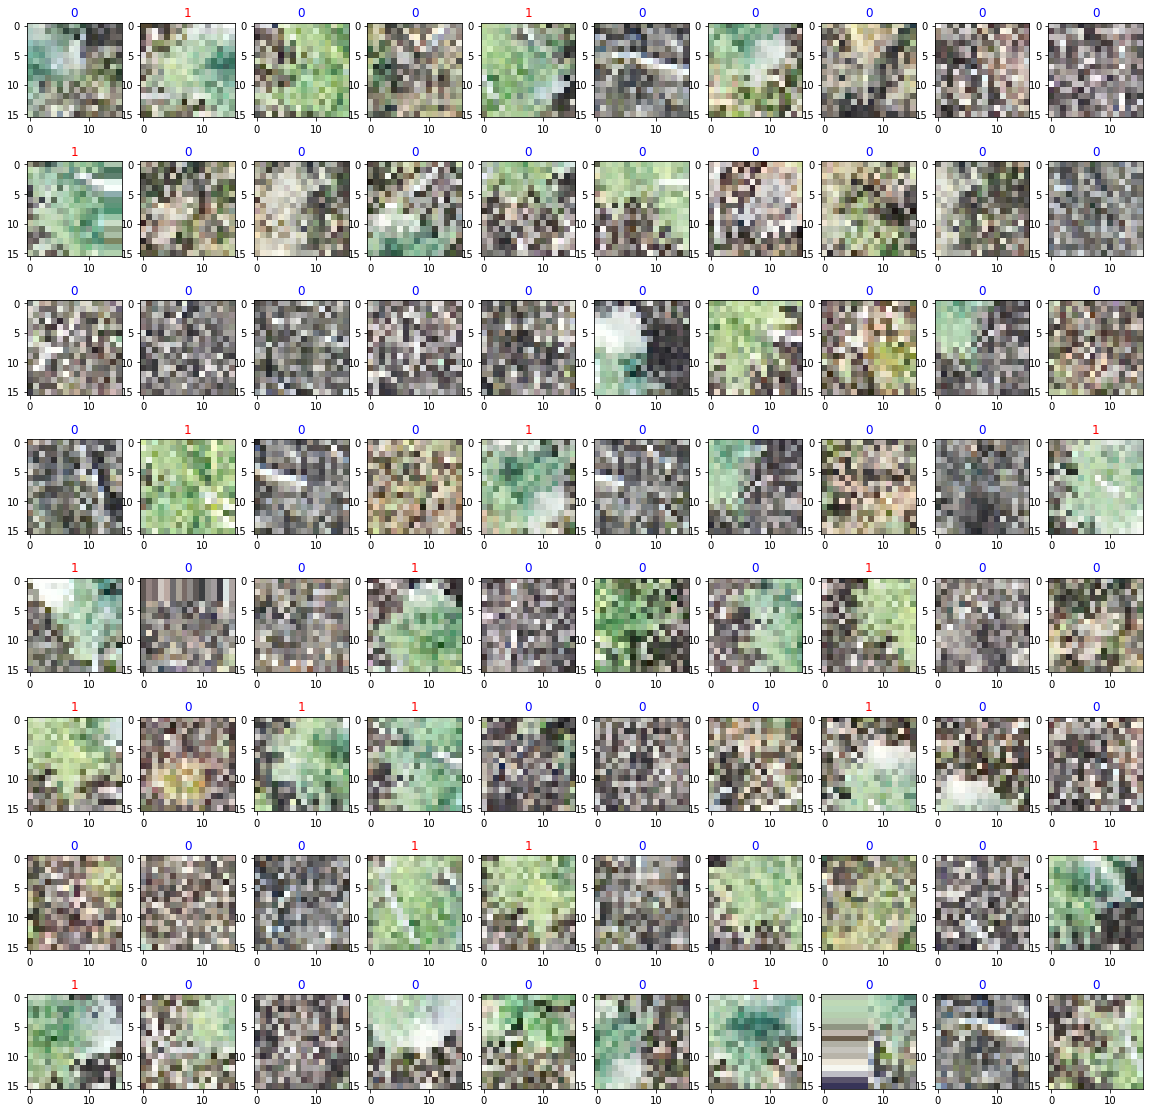

time: 8.87 s


In [0]:
fig=plt.figure(figsize=(20, 20))
columns = 10
rows = 8
for i in range(1, columns*rows +1):
    sample = np.random.randint(0, xs_train_Color.shape[0] - 1)
    ax = fig.add_subplot(rows, columns, i)
    ax.set_title(str(ys_train[sample]), color=('red' if ys_train[sample] == 1 else 'blue'))
    plt.imshow(xs_train_Color[sample, :3, ...].swapaxes(0, 2), vmin=0, vmax=1)
plt.show()

# Model

In [0]:
class MyNetColor(nn.Module):
    def __init__(self):
        super(MyNetColor, self).__init__()
        # 2**4 x 2**4 x 5
        self.conv_layers = nn.Sequential(nn.Conv2d(4, 32, 3, padding=1), #  2**4
                                         nn.ReLU(),
                                         nn.Conv2d(32, 32, 3, padding=1), #  2**4
                                         nn.ReLU(),
                                         nn.MaxPool2d(2), #  2**3
                                         
                                         nn.Conv2d(32, 64, 3, padding=1), # 2**3
                                         nn.ReLU(),
                                         nn.BatchNorm2d(64),
                                         nn.Conv2d(64, 64, 3, padding=1), # 2**3
                                         nn.ReLU(),
                                         nn.MaxPool2d(2), #  2**2

                                         nn.Conv2d(64, 128, 3, padding=1), #  2**2
                                         nn.ReLU(),
                                         nn.Dropout(),
                                         nn.BatchNorm2d(128),
                                         nn.Conv2d(128, 128, 3, padding=1), #  2**2
                                         nn.ReLU(),
                                         nn.MaxPool2d(2), #  2**1

                                         nn.Conv2d(128, 256, 2, padding=0), #  2**0
                                         nn.ReLU(),
                                         nn.Dropout(),
                                         nn.Conv2d(256, 1, 1, padding=0)) #  2**0
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.sum((2, 3))
        #x = np.squeeze(x)
        x = self.sigmoid(x)
        return x

time: 32.1 ms


In [0]:
class MyNetPosition(nn.Module):
    def __init__(self):
        super(MyNetPosition, self).__init__()

        self.r = nn.Parameter(torch.tensor([0.0, 0.0]))
        self.n = 10
        self.b = nn.Parameter(torch.tensor([[0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            #[0.0, 0.0],
                                            #[0.0, 0.0],
                                            #[0.0, 0.0],
                                            #[0.0, 0.0],
                                            #[0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0]]))
        self.A = nn.Parameter(torch.tensor([[5.5, 5.5],
                                            [6.5, 6.5],
                                            [7.5, 7.5],
                                            [8.5, 8.5],
                                            [9.5, 9.5],
                                            [10.5, 10.5],
                                            [11.5, 11.5],
                                            [12.5, 12.5],
                                            [13.5, 13.5],
                                            [14.5, 14.5]
                                            #[15.5, 15.5],
                                            #[16.5, 16.5],
                                            #[17.5, 17.5],
                                            #[18.5, 18.5],
                                            #[19.5, 19.5]
                                            ]))
        self.C = nn.Parameter(torch.tensor([[1.0 / self.n, 1.0 / self.n],
                                            [1.0 / self.n, 1.0 / self.n],
                                            [1.0 / self.n, 1.0 / self.n],
                                            [1.0 / self.n, 1.0 / self.n],
                                            [1.0 / self.n, 1.0 / self.n],
                                            [1.0 / self.n, 1.0 / self.n],
                                            [1.0 / self.n, 1.0 / self.n],
                                            [1.0 / self.n, 1.0 / self.n],
                                            #[1.0 / self.n, 1.0 / self.n],
                                            #[1.0 / self.n, 1.0 / self.n],
                                            #[1.0 / self.n, 1.0 / self.n],
                                            #[1.0 / self.n, 1.0 / self.n],
                                            #[1.0 / self.n, 1.0 / self.n],
                                            [1.0 / self.n, 1.0 / self.n], 
                                            [1.0 / self.n, 1.0 / self.n]]))
        self.H = nn.Parameter(torch.tensor([[0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            #[0.0, 0.0],
                                            #[0.0, 0.0],
                                            #[0.0, 0.0],
                                            #[0.0, 0.0],
                                            #[0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0],
                                            [0.0, 0.0]]))
        
        self.sigmoid = nn.Sigmoid()

        self.swapColsIndices = torch.tensor([1, 0]).to(TORCH_DEVICE)

    def forward(self, x):  # (N, Y, X)

        x += self.r * torch.index_select(x, 1, self.swapColsIndices)

        ax = torch.mm(x[..., 0].unsqueeze(1), self.A[..., 0].unsqueeze(0))
        ay = torch.mm(x[..., 1].unsqueeze(1), self.A[..., 1].unsqueeze(0))

        x = torch.cat((ax.unsqueeze(2), ay.unsqueeze(2)), 2)
        x += self.b
        x *= 2 * np.pi
        x = torch.sin(x)
        x += self.H
        x *= self.C
        x = torch.sum(x, (1, 2))
        
        return self.sigmoid(x)

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.positionModel = MyNetPosition()

    def forward(self, x_color, x_position):
        x_position = self.positionModel(x_position)
        return x_position

time: 71 ms


In [0]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.positionModel = MyNetPosition()
        self.colorModel = MyNetColor()
        self.affine = nn.Linear(2, 1)
        #self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x_color, x_colorPosChannel, x_position):
        x_position = self.positionModel(x_position)

        x_colorPosChannel_Shape = x_colorPosChannel.shape[:-1]
        #print("x_colorPosChannel_Shape", x_colorPosChannel_Shape)
        x_colorPosChannel = self.positionModel(x_colorPosChannel.view((x_colorPosChannel_Shape[0] * x_colorPosChannel_Shape[1] * x_colorPosChannel_Shape[2], 2)))
        x_colorPosChannel = x_colorPosChannel.view(x_colorPosChannel_Shape).unsqueeze(1)
        
        #print("x_colorPosChannel", x_colorPosChannel.shape)
                
        #print(x_color.shape)
        x_colorIn = torch.cat((x_color, x_colorPosChannel), 1)
        #print(x_colorIn.shape)

        x_color = self.colorModel(x_colorIn)
        x_position = torch.unsqueeze(x_position, 1)

        #print(x_color.shape)
        #print(x_position.shape)
        x = torch.cat((x_color, x_position), 1)
        #print(x.shape)
        x = self.affine(x)
        x = torch.squeeze(x)
        x = self.sigmoid(x)
        return x, torch.squeeze(x_color), torch.squeeze(x_position)

time: 23 ms


# Train

In [0]:
net = MyNet()
net.to(TORCH_DEVICE)

optimizer = torch.optim.Adadelta(net.parameters())#, weight_decay=0.1)
criterion = nn.BCELoss()

bar = display(progress(0, 100), display_id=True)

epochs = 8
for e in range(epochs):
    print("Epoch", e, end=" ")
    runningLoss = 0
    
    batchSize = len(train_dataloader)
    batchCount = 0
    bar.update(progress(batchCount, batchSize))

    for batchXColor, batchXColor_PosChannel, batchXPosition, batchY in train_dataloader:
        batchXColor, batchXColor_PosChannel, batchXPosition, batchY = batchXColor.to(TORCH_DEVICE), batchXColor_PosChannel.to(TORCH_DEVICE), batchXPosition.to(TORCH_DEVICE), batchY.to(TORCH_DEVICE)
        optimizer.zero_grad()  # zero the gradient buffers
        batchY_pred, batchY_pred_color, batchY_pred_position = net(batchXColor, batchXColor_PosChannel, batchXPosition)
        #testLoss = criterion(batchY_pred, batchY)
        testLoss = criterion(batchY_pred, batchY) + criterion(batchY_pred_color, batchY) + criterion(batchY_pred_position, batchY)
        testLoss.backward()
        optimizer.step()
        runningLoss += testLoss.item()

        batchCount += 1
        bar.update(progress(batchCount, batchSize))

    print("Test-Loss", runningLoss, end=" ")

    # -- Test
    with torch.no_grad():
        ys_test_pred = net(tensor_xs_test_Color.to(TORCH_DEVICE), tensor_xs_test_Color_PosChannel.to(TORCH_DEVICE), tensor_xs_test_Position.to(TORCH_DEVICE))[0].cpu()
    #print()
    prediction = np.around(ys_test_pred.numpy())
    #print(prediction.tolist())
    accuracy = float((prediction == ys_test).sum()) / ys_test.shape[0]
    print("Accuracy", accuracy)

Epoch 0 Test-Loss 411.8055275082588 Accuracy 0.8240387945964669
Epoch 1 Test-Loss 261.0687144398689 Accuracy 0.9587807412538968
Epoch 2 Test-Loss 212.29006707668304 Accuracy 0.9567024593003117
Epoch 3 Test-Loss 183.79096993803978 Accuracy 0.9795635607897472
Epoch 4 Test-Loss 161.7029057443142 Accuracy 0.969864911673017
Epoch 5 Test-Loss 150.33111256361008 Accuracy 0.971943193626602
Epoch 6 Test-Loss 138.54045659303665 Accuracy 0.9906477312088673
Epoch 7 Test-Loss 133.24405820667744 Accuracy 0.9920332525112574
time: 59.8 s


In [0]:
print("r", net.positionModel.r.data)
print("b", net.positionModel.b.data)
print("A", net.positionModel.A.data)
print("C", net.positionModel.C.data)
print("H", net.positionModel.H.data)
print("affine combination", net.affine.weight)

r tensor([-0.0528, -0.0701], device='cuda:0')
b tensor([[ 0.3046, -0.1630],
        [ 0.1817, -0.2516],
        [-0.2717,  0.3665],
        [ 0.1869, -0.2123],
        [ 0.1432,  0.0715],
        [-0.0983, -0.2721],
        [ 0.2942,  0.2193],
        [ 0.0134, -0.1795],
        [ 0.3038,  0.0978],
        [ 0.0872, -0.1890]], device='cuda:0')
A tensor([[ 5.3329,  5.5285],
        [ 6.3359,  6.3330],
        [ 7.6062,  7.6159],
        [ 8.2866,  8.4327],
        [ 9.5387,  9.4331],
        [10.2787, 10.5562],
        [11.3802, 11.6116],
        [12.5233, 12.4092],
        [13.3664, 13.5288],
        [14.4774, 14.3689]], device='cuda:0')
C tensor([[ 0.1047,  0.9073],
        [ 0.1088,  0.8192],
        [ 0.4435,  1.5704],
        [ 0.2291,  1.6335],
        [ 0.1301,  0.3422],
        [-0.2922,  0.3491],
        [ 0.0396,  0.2429],
        [ 0.3722, -0.3095],
        [ 0.2476,  0.8397],
        [ 0.0697,  0.2367]], device='cuda:0')
H tensor([[-0.2457, -0.4237],
        [-0.3329, -0.312

# Inference

In [0]:
ys_eval_Combined, ys_eval_Color, ys_eval_Position = (None, None, None)
#ys_eval_Combined, ys_eval_Color, ys_eval_Position = (np.empty(0), np.empty(0), np.empty(0))
net.train(False)
with torch.no_grad():
    for batchXColor, batchXColor_PosChannel, batchXPosition in inference_dataloader:
        batchXColor, batchXColor_PosChannel, batchXPosition = batchXColor.to(TORCH_DEVICE), batchXColor_PosChannel.to(TORCH_DEVICE), batchXPosition.to(TORCH_DEVICE)
        batchY_pred, batchY_pred_color, batchY_pred_position = net(batchXColor, batchXColor_PosChannel, batchXPosition)
        batchY_pred = batchY_pred.cpu().numpy()
        batchY_pred_color = batchY_pred_color.cpu().numpy()
        batchY_pred_position = batchY_pred_position.cpu().numpy()
        ys_eval_Combined = np.concatenate((ys_eval_Combined, batchY_pred)) if ys_eval_Combined is not None else batchY_pred
        ys_eval_Color = np.concatenate((ys_eval_Color, batchY_pred_color)) if ys_eval_Color is not None else batchY_pred_color
        ys_eval_Position = np.concatenate((ys_eval_Position, batchY_pred_position)) if ys_eval_Position is not None else batchY_pred_position

        #np.concatenate((ys_eval_Combined, batchY_pred.cpu().numpy()))
        #np.concatenate((ys_eval_Color, batchY_pred_color.cpu().numpy()))
        #np.concatenate((ys_eval_Position, batchY_pred_position.cpu().numpy()))
        #print(ys_eval_Combined.shape)

time: 17.8 s


In [0]:
print(ys_eval_Color.shape)
print(ys_eval_Position.shape)
print(ys_eval_Combined.shape)

(354294,)
(354294,)
(354294,)
time: 2.23 ms


# Display and Validate

In [0]:
def createImageFromYs(ys):
    #resultImage = ys[:, 0]
    resultImage = ys * 255
    resultImage = resultImage.reshape((imageHeight, imageWidth))
    resultImage = resultImage.astype(np.uint8, order='C', casting='unsafe')
    return resultImage

time: 5.45 ms


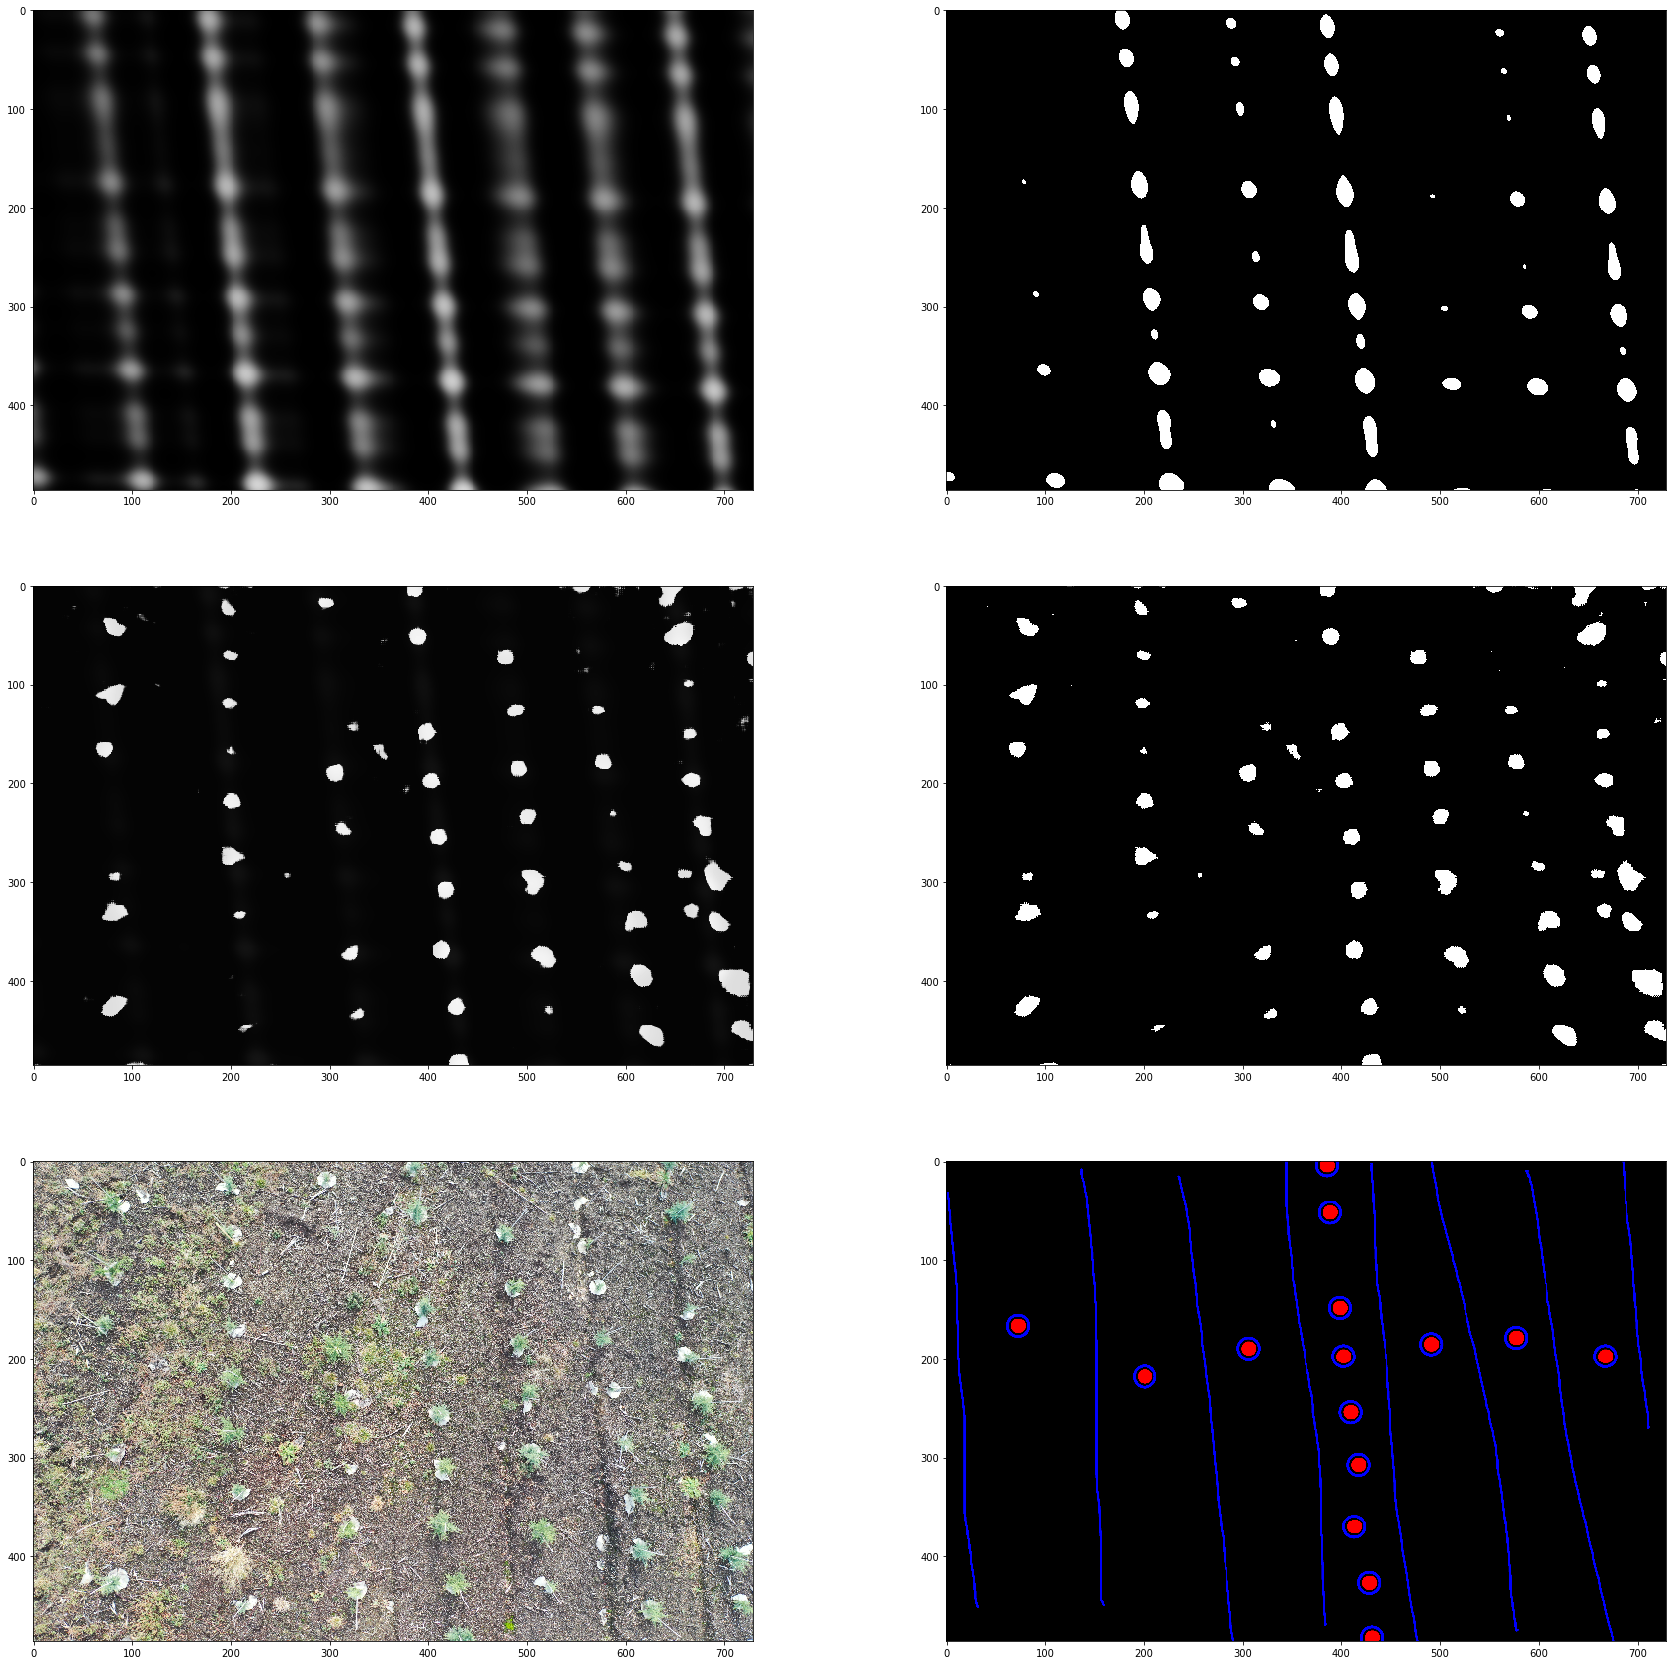

time: 2.31 s


In [0]:
fig, axs = plt.subplots(3, 2, figsize=(30, 3 * 10))

#resultImage = createImageFromYs(ys_eval_Color)
#resultImageThresh = cv2.threshold(resultImage, 127, 255, cv2.THRESH_BINARY)[1]
#axs[0, 0].imshow(resultImage, cmap='gray', vmin=0, vmax=255)
#axs[0, 1].imshow(resultImageThresh, cmap='gray', vmin=0, vmax=255)

resultImage = createImageFromYs(ys_eval_Position)
resultImageThresh = cv2.threshold(resultImage, 127, 255, cv2.THRESH_BINARY)[1]
axs[0, 0].imshow(resultImage, cmap='gray', vmin=0, vmax=255)
axs[0, 1].imshow(resultImageThresh, cmap='gray', vmin=0, vmax=255)

resultImage = cv2.cvtColor(resultImage, cv2.COLOR_GRAY2RGBA)
resultImageThresh = cv2.cvtColor(resultImageThresh, cv2.COLOR_GRAY2RGBA)
resultOverlap = cv2.addWeighted(resultImage, 1.0, scribbleMatOriginalWithAlpha, 0.5, 0.0)
resultImageThresh = cv2.addWeighted(resultImageThresh, 1.0, scribbleMatOriginalWithAlpha, 0.5, 0.0)

resultImage = createImageFromYs(ys_eval_Combined)
resultImageThresh = cv2.threshold(resultImage, 127, 255, cv2.THRESH_BINARY)[1]
axs[1, 0].imshow(resultImage, cmap='gray', vmin=0, vmax=255)
axs[1, 1].imshow(resultImageThresh, cmap='gray', vmin=0, vmax=255)

axs[2, 0].imshow(colorMat, vmin=0, vmax=255)
axs[2, 1].imshow(scribbleMat, vmin=0, vmax=255)
plt.show()

In [0]:
print("resultImageThresh", resultImageThresh.shape, resultImageThresh.size)
print("validationMat", validationMat.shape, validationMat.size)

print((validationMat.flatten() != resultImageThresh.flatten()).sum())

print()
groundTruth = validationMat.flatten() != 0
prediction = resultImageThresh.flatten() != 0
accuracy = sklearn.metrics.accuracy_score(prediction, groundTruth)
print("Overall Accuracy", accuracy)
confusion_matrix = sklearn.metrics.confusion_matrix(groundTruth, prediction)
print("Confusion matrix", confusion_matrix)
tp = float(confusion_matrix[1, 1])
tn = float(confusion_matrix[0, 0])
fp = float(confusion_matrix[0, 1])
fn = float(confusion_matrix[1, 0])
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
print("Sensitivity / Sensitivität", sensitivity)
print("Specificity / Spezifität", specificity)
print("Precision / Positiver Vorhersagewert", precision)
f1 = sklearn.metrics.f1_score(groundTruth != 0, prediction != 0)
print("F1", f1)
jaccard = sklearn.metrics.jaccard_score(groundTruth, prediction)
print("Jaccard", jaccard)
matthewsCorrelationCoefficient = sklearn.metrics.matthews_corrcoef(groundTruth, prediction)
print("Matthews correlation coefficient", matthewsCorrelationCoefficient)



labels = measure.label(validationMat)
validCount = labels.max()
print("validation count ", validCount)

labels = measure.label(resultImageThresh)
#print("prediction count", labels.max())
predCount = np.bincount(labels.flatten())
predCount = len(predCount[np.where(predCount > 50)]) - 1
print("prediction count", predCount)

accuracy = 1 - (abs(validCount - predCount) / validCount)
print("accuracy", accuracy)


#np.set_printoptions(threshold=sys.maxsize)
#print(labels)

resultImageThresh (486, 729) 354294
validationMat (486, 729) 354294
11943

Overall Accuracy 0.9662907077173195
Confusion matrix [[332257   2561]
 [  9382  10094]]
Sensitivity / Sensitivität 0.5182789073731773
Specificity / Spezifität 0.9923510683416065
Precision / Positiver Vorhersagewert 0.7976293954958514
F1 0.6283028850642681
Jaccard 0.45804782865181287
Matthews correlation coefficient 0.6271129828846626
validation count  55
prediction count 56
accuracy 0.9818181818181818
time: 907 ms


In [0]:
'''
# Info
print("shape: ", resultImageThresh.shape, resultImageThresh.size)
print("result 1", (resultImageThresh == 255).sum())
print("valida 1", (validationMat == 255).sum())
print("result 1 without valida 1", (resultImageThresh > validationMat).sum())
print("valida 1 without result 1", (validationMat > resultImageThresh).sum())

# Validation with ground truth mask
validationAccuracy = float((resultImageThresh == validationMat).sum()) / validationMat.size
print("validationAccuracy", validationAccuracy)

print()
print("Hit (intersect): ", (resultImageThresh == 255).sum() - (resultImageThresh > validationMat).sum())
print("Miss:            ", (validationMat > resultImageThresh).sum())
print("FalseAlarm:      ", (resultImageThresh > validationMat).sum())
print("CorrectRejection:", (resultImageThresh == validationMat).sum() - ((resultImageThresh == 255).sum() - (resultImageThresh > validationMat).sum()))
print()

# Intersection Over Union
intersection = (resultImageThresh == 255).sum() - (resultImageThresh > validationMat).sum()
print("Intersection", intersection)
union = (resultImageThresh == 255).sum() + (validationMat == 255).sum() - intersection
print("Union", union)
iou = float(intersection) / float(union)
print("Intersection Over Union", iou)
'''

'\n# Info\nprint("shape: ", resultImageThresh.shape, resultImageThresh.size)\nprint("result 1", (resultImageThresh == 255).sum())\nprint("valida 1", (validationMat == 255).sum())\nprint("result 1 without valida 1", (resultImageThresh > validationMat).sum())\nprint("valida 1 without result 1", (validationMat > resultImageThresh).sum())\n\n# Validation with ground truth mask\nvalidationAccuracy = float((resultImageThresh == validationMat).sum()) / validationMat.size\nprint("validationAccuracy", validationAccuracy)\n\nprint()\nprint("Hit (intersect): ", (resultImageThresh == 255).sum() - (resultImageThresh > validationMat).sum())\nprint("Miss:            ", (validationMat > resultImageThresh).sum())\nprint("FalseAlarm:      ", (resultImageThresh > validationMat).sum())\nprint("CorrectRejection:", (resultImageThresh == validationMat).sum() - ((resultImageThresh == 255).sum() - (resultImageThresh > validationMat).sum()))\nprint()\n\n# Intersection Over Union\nintersection = (resultImageThre

time: 6.37 ms


In [0]:
'''
# View position result only
fig, axs = plt.subplots(3, 2, figsize=(30, 3 * 10))

resultImage = createImageFromYs(ys_eval_Position)
resultImageThresh = cv2.threshold(resultImage, 127, 255, cv2.THRESH_BINARY)[1]
axs[0, 0].imshow(resultImage, cmap='gray', vmin=0, vmax=255)
axs[0, 1].imshow(resultImageThresh, cmap='gray', vmin=0, vmax=255)

resultImage = cv2.cvtColor(resultImage, cv2.COLOR_GRAY2RGBA)
resultImageThresh = cv2.cvtColor(resultImageThresh, cv2.COLOR_GRAY2RGBA)
resultOverlap = cv2.addWeighted(resultImage, 1.0, scribbleMatOriginalWithAlpha, 0.5, 0.0)
resultImageThresh = cv2.addWeighted(resultImageThresh, 1.0, scribbleMatOriginalWithAlpha, 0.5, 0.0)

axs[1, 0].imshow(resultOverlap, vmin=0, vmax=255)
axs[1, 1].imshow(resultImageThresh, vmin=0, vmax=255)

axs[2, 0].imshow(colorMat, vmin=0, vmax=255)
axs[2, 1].imshow(scribbleMat, vmin=0, vmax=255)
plt.show()
'''

"\n# View position result only\nfig, axs = plt.subplots(3, 2, figsize=(30, 3 * 10))\n\nresultImage = createImageFromYs(ys_eval_Position)\nresultImageThresh = cv2.threshold(resultImage, 127, 255, cv2.THRESH_BINARY)[1]\naxs[0, 0].imshow(resultImage, cmap='gray', vmin=0, vmax=255)\naxs[0, 1].imshow(resultImageThresh, cmap='gray', vmin=0, vmax=255)\n\nresultImage = cv2.cvtColor(resultImage, cv2.COLOR_GRAY2RGBA)\nresultImageThresh = cv2.cvtColor(resultImageThresh, cv2.COLOR_GRAY2RGBA)\nresultOverlap = cv2.addWeighted(resultImage, 1.0, scribbleMatOriginalWithAlpha, 0.5, 0.0)\nresultImageThresh = cv2.addWeighted(resultImageThresh, 1.0, scribbleMatOriginalWithAlpha, 0.5, 0.0)\n\naxs[1, 0].imshow(resultOverlap, vmin=0, vmax=255)\naxs[1, 1].imshow(resultImageThresh, vmin=0, vmax=255)\n\naxs[2, 0].imshow(colorMat, vmin=0, vmax=255)\naxs[2, 1].imshow(scribbleMat, vmin=0, vmax=255)\nplt.show()\n"

time: 6.22 ms


In [0]:
'''
fig=plt.figure(figsize=(20, 20))
columns = 10
rows = 8
for i in range(1, columns*rows +1):
    sample = np.random.randint(0, ys_eval.shape[0] - 1)
    ax = fig.add_subplot(rows, columns, i)
    ax.set_title(str(ys_eval_Combined[sample]), color=('red' if ys_eval[sample] > 0.5 else 'blue'))
    plt.imshow(xs_eval[sample, :3, ...].swapaxes(0, 2), vmin=0, vmax=1)
plt.show()
'''

"\nfig=plt.figure(figsize=(20, 20))\ncolumns = 10\nrows = 8\nfor i in range(1, columns*rows +1):\n    sample = np.random.randint(0, ys_eval.shape[0] - 1)\n    ax = fig.add_subplot(rows, columns, i)\n    ax.set_title(str(ys_eval_Combined[sample]), color=('red' if ys_eval[sample] > 0.5 else 'blue'))\n    plt.imshow(xs_eval[sample, :3, ...].swapaxes(0, 2), vmin=0, vmax=1)\nplt.show()\n"

time: 6.44 ms


# Save